## CIFAR-10 Data Preprocessing for Hopfield Networks and Phase Space Learning

### Step 1: Install and Import Required Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# import models
from hopfield_baseline import HopfieldRNN

### Step 2: Load the CIFAR-10 Dataset

In [16]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

Training set size: 50000, Test set size: 10000


### Step 3: Binarize the Images to -1/+1

In [3]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [ ]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

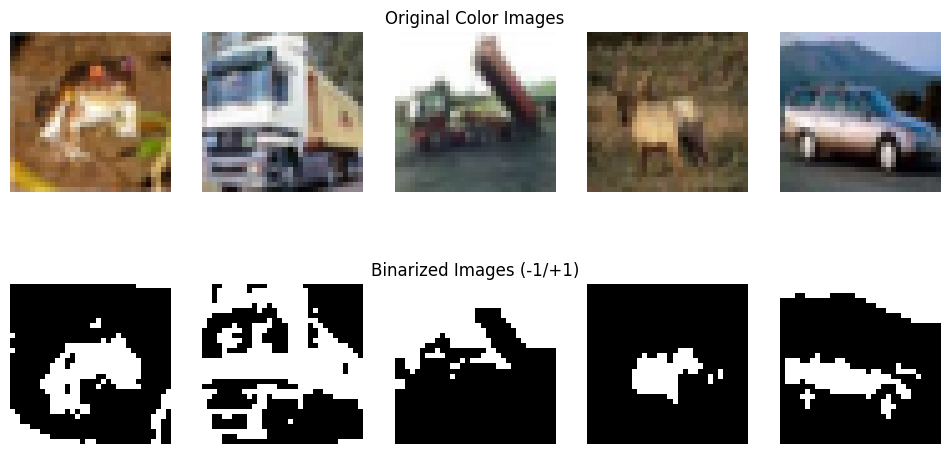

In [20]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [24]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [25]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

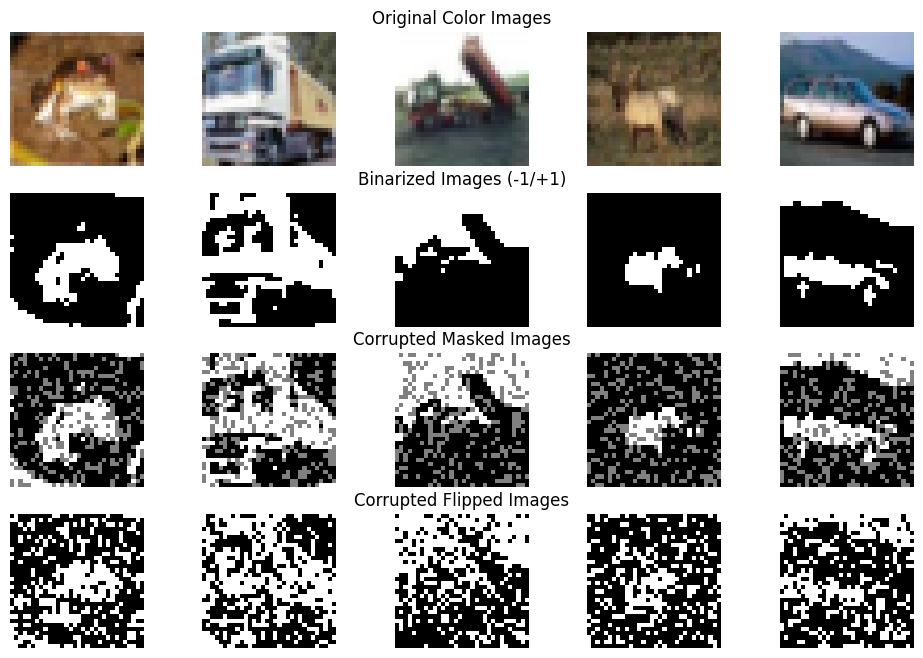

In [29]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [30]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)


### Training

In [3]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [4]:
num_neurons = 1024
num_patterns = 5
hopfield_rnn = HopfieldRNN(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

# store patterns using Hebbian learning
hopfield_rnn.store_patterns(stored_images[idxs])

In [5]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_rnn(masked_images[idxs])
retrieved_flipped = hopfield_rnn(flipped_images[idxs])


In [6]:
criterion = nn.MSELoss()

loss_masked = criterion(stored_images[idxs], retrieved_masked)
loss_flipped = criterion(stored_images[idxs], retrieved_flipped)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}\n")

# Compute SSE using PyTorch's MSE function with reduction='sum'
loss_masked = hopfield_rnn.recall_loss(masked_images[idxs], stored_images[idxs])
loss_flipped = hopfield_rnn.recall_loss(flipped_images[idxs], stored_images[idxs])

print(f"Reconstruction Loss (Masked Images - SSE): {loss_masked.item():.4f}")
print(f"Reconstruction Loss (Flipped Images - SSE): {loss_flipped.item():.4f}\n")

masked_acc = hopfield_rnn.recall_accuracy(masked_images[idxs], stored_images[idxs])
flipped_acc = hopfield_rnn.recall_accuracy(flipped_images[idxs], stored_images[idxs])

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.0094
Reconstruction MSE Loss (Flipped Images): 0.1469

Reconstruction Loss (Masked Images - SSE): 48.0000
Reconstruction Loss (Flipped Images - SSE): 752.0000

Reconstruction Accuracy (Masked Images): 0.8000
Reconstruction Accuracy (Flipped Images): 0.6000


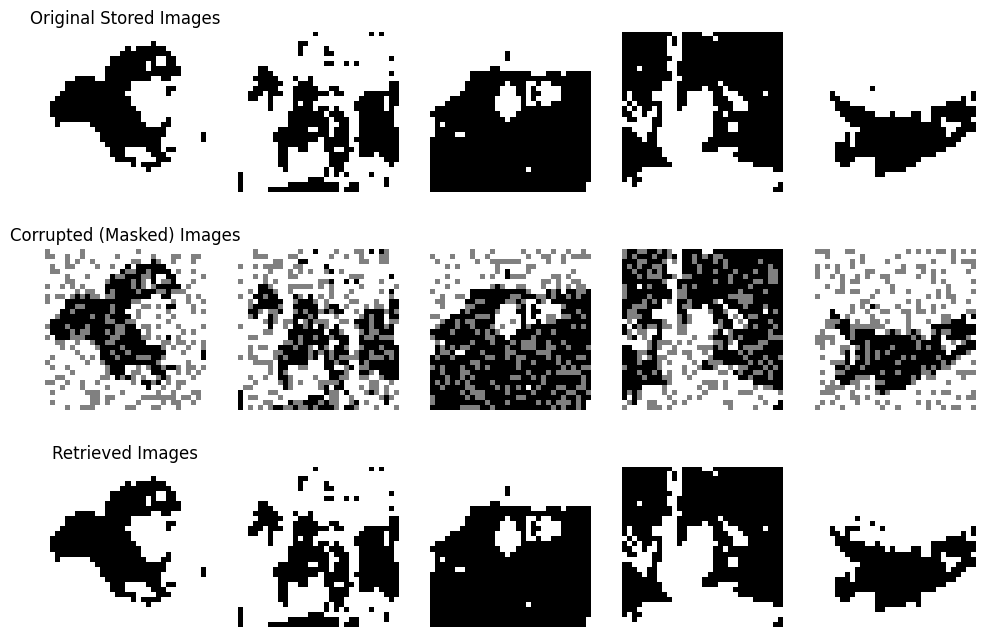

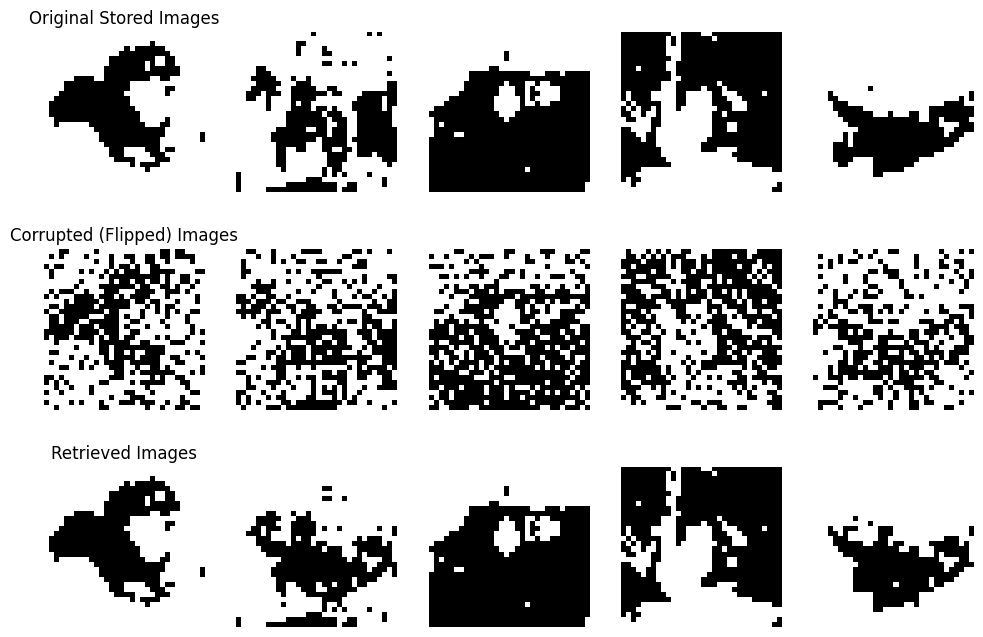

In [7]:
import matplotlib.pyplot as plt

def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')

    plt.show()

# Plot results for masked images
plot_comparisons(stored_images.numpy()[idxs], masked_images.numpy()[idxs], retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(stored_images.numpy()[idxs], flipped_images.numpy()[idxs], retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")


## Baseline Hopfield Model

In [80]:
# Hyperparameters
batch_size = 1
learning_rate = 1e-4
epochs = 10

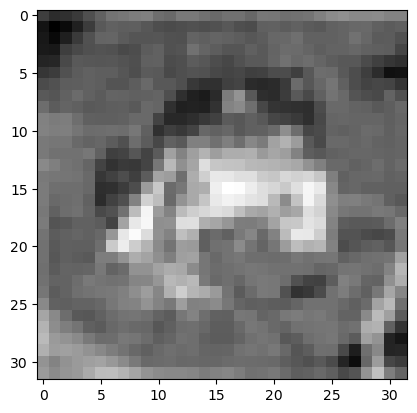

In [19]:
data = train_dataset[0][0]
import matplotlib.pyplot as plt
# img = data.permute(1, 2, 0).numpy()
img = data[0]
plt.imshow(img, cmap="gray")

In [21]:
img

tensor([[0.2392, 0.1765, 0.1882,  ..., 0.5373, 0.5098, 0.5059],
        [0.0745, 0.0000, 0.0392,  ..., 0.3725, 0.3529, 0.3686],
        [0.0941, 0.0353, 0.1216,  ..., 0.3529, 0.3569, 0.3137],
        ...,
        [0.6784, 0.6039, 0.6157,  ..., 0.5255, 0.1412, 0.1490],
        [0.5725, 0.5059, 0.5647,  ..., 0.6000, 0.2706, 0.2353],
        [0.5922, 0.5373, 0.5765,  ..., 0.7412, 0.4863, 0.3882]])

In [23]:
tensor_255 = (img * 255).to(torch.uint8)
tensor_255

tensor([[ 61,  45,  48,  ..., 137, 130, 129],
        [ 19,   0,  10,  ...,  95,  90,  94],
        [ 24,   9,  31,  ...,  90,  91,  80],
        ...,
        [173, 154, 157,  ..., 134,  36,  38],
        [146, 129, 144,  ..., 153,  69,  60],
        [151, 137, 147,  ..., 189, 124,  99]], dtype=torch.uint8)

# Image Encoding and Decoding

In [28]:
def encode(img):
    flat = img.flatten()
    flat_np = flat.numpy().astype(np.uint8)
    bits = np.unpackbits(flat_np.reshape(-1, 1), axis=1)
    encoded = 2 * bits - 1
    encoded_flat = encoded.flatten()
    return torch.tensor(encoded_flat, dtype=torch.int8)

In [75]:
def decode(encoded):
    encoded_reshaped = encoded.reshape(-1, 8)
    bits = ((encoded_reshaped + 1) // 2).numpy().astype(np.uint8)
    pixels = np.packbits(bits, axis=1)
    pixels = pixels.squeeze(1)
    
    img = torch.from_numpy(pixels).reshape(32, 32)
    return img

In [45]:
imgenc = encode(tensor_255)
print(imgenc)
len(imgenc)

tensor([-1, -1,  1,  ..., -1,  1,  1], dtype=torch.int8)


8192

In [44]:
img2 = decode(imgenc)
img2


32

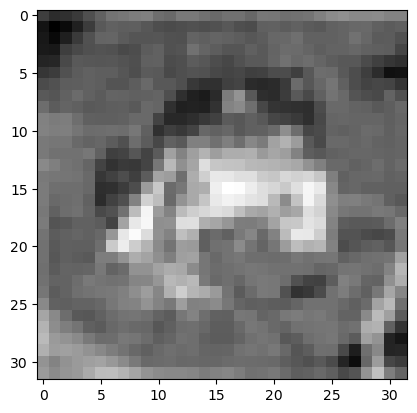

In [37]:
plt.imshow(img2, cmap="gray")

# Data Preparing

In [55]:
data = []
for i in range(2):
    fig = train_dataset[i][0]
    tensor_fig = (fig * 255).to(torch.uint8)
    fig_enc = encode(tensor_fig).to(torch.float)
    data.append(fig_enc)

loader = DataLoader(data, batch_size=batch_size, shuffle=False)

# Main

In [82]:
class HopfieldNet(nn.Module):
    def __init__(self):
        super(HopfieldNet, self).__init__()
        self.dropout = nn.Dropout(p=0.25)
        self.skip = nn.Linear(8192, 8192)
        self.down = nn.Linear(8192, 100)
        self.up   = nn.Linear(100, 8192)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.dropout(x)
        x_skip = self.skip(x)
        x_hidden = self.activation(self.down(x))
        x_hidden = self.activation(self.up(x_hidden))
        return x_skip + x_hidden

In [83]:
model = HopfieldNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [84]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs in loader:
        optimizer.zero_grad()          # Clear gradients
        outputs = model(inputs)          # Forward pass
        loss = criterion(outputs, inputs)  # Compute reconstruction loss
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [1/10], Loss: 1.514116
Epoch [2/10], Loss: 0.586656
Epoch [3/10], Loss: 0.330015
Epoch [4/10], Loss: 0.395496
Epoch [5/10], Loss: 0.464758
Epoch [6/10], Loss: 0.444534
Epoch [7/10], Loss: 0.371025
Epoch [8/10], Loss: 0.299912
Epoch [9/10], Loss: 0.259813
Epoch [10/10], Loss: 0.246000


In [85]:
out1 = model(data[0])
binary_out = np.where(out1 < 0, -1, 1)

In [87]:
img_out = decode(binary_out)

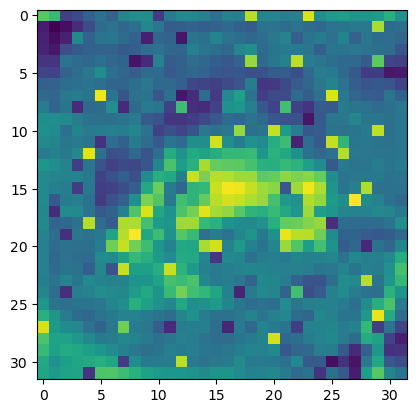

In [88]:
plt.imshow(img_out)